In [2]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
import statsmodels.tsa.vector_ar.var_model as VAR
from datetime import datetime
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Load data

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:146: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:148: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:33: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:36: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future versio

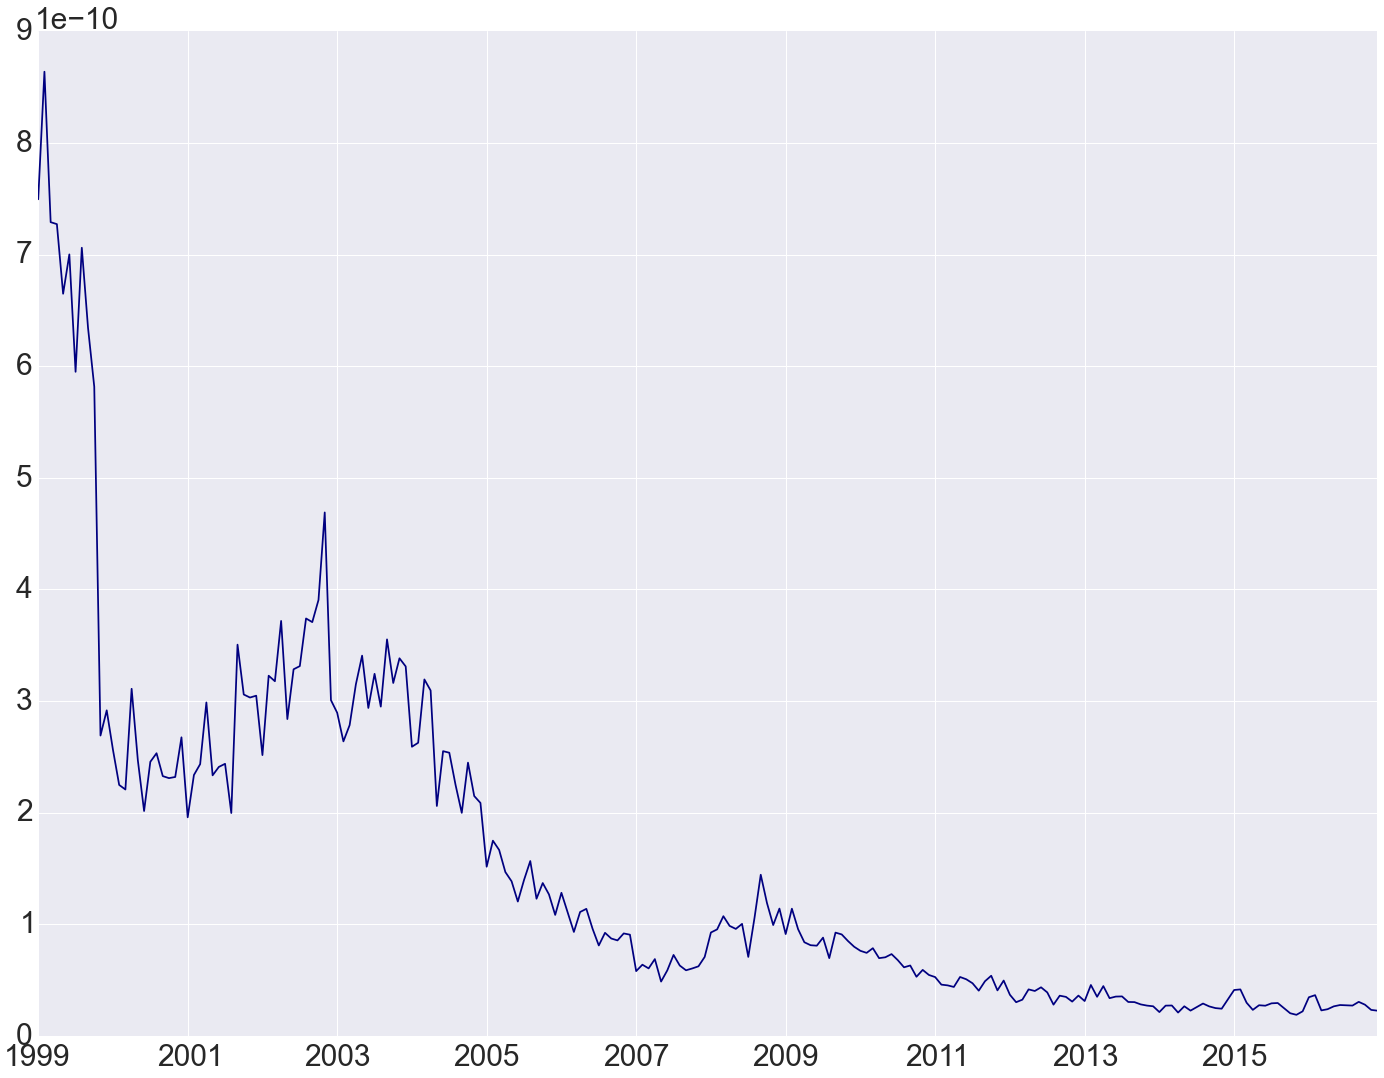

In [5]:
amihud.median(axis=1).dropna().plot(colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


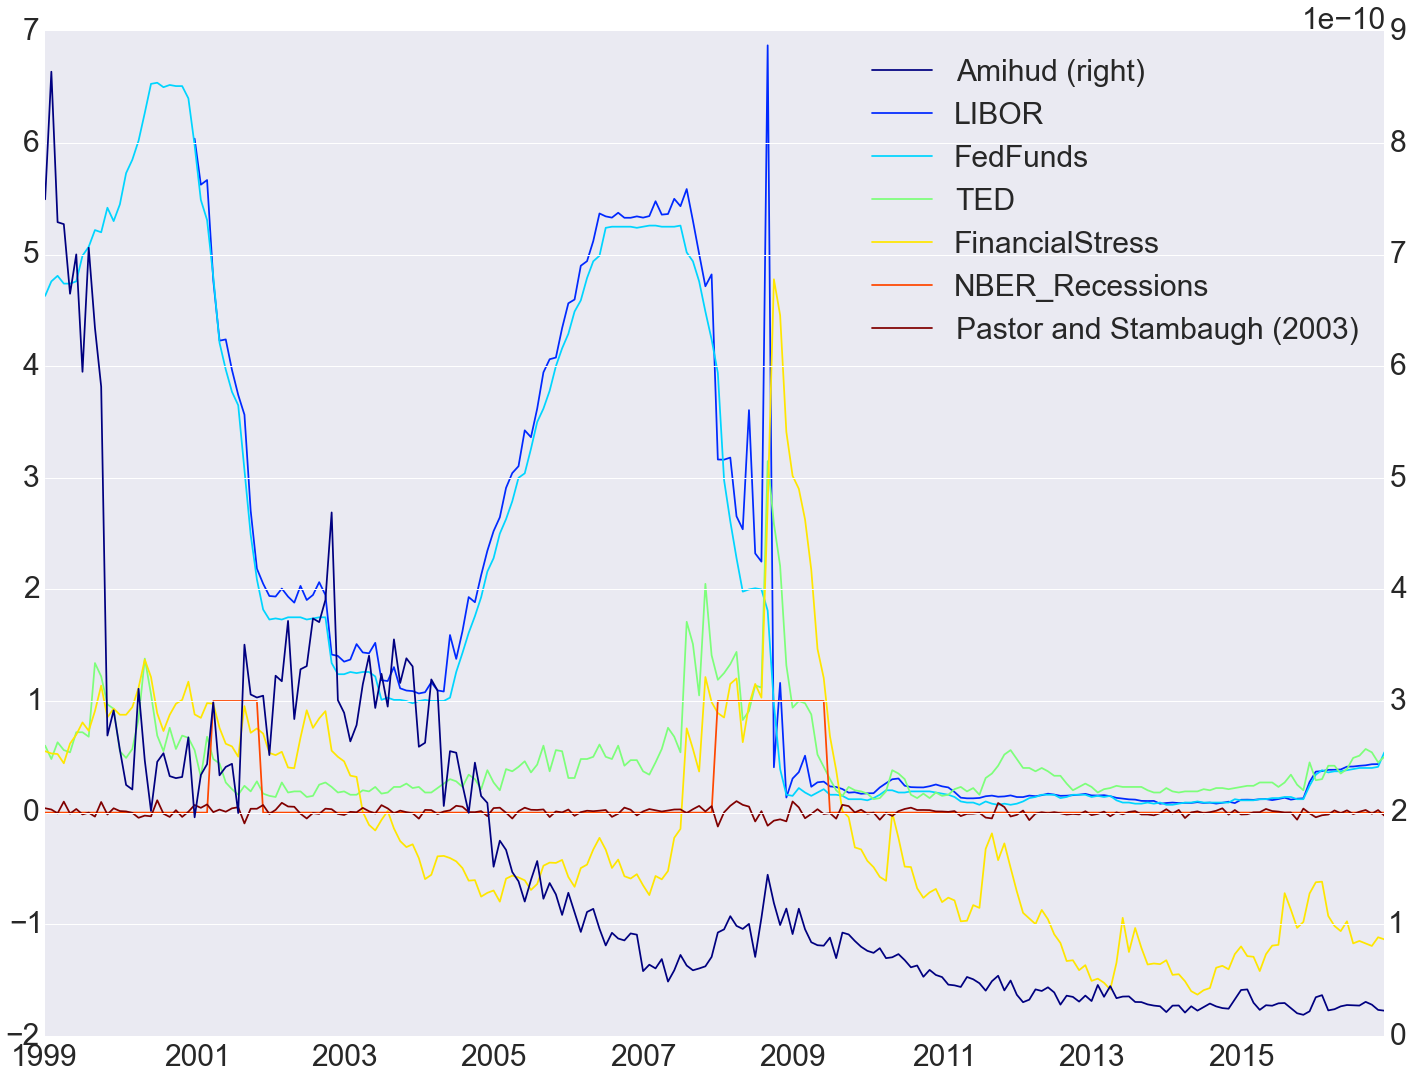

In [8]:
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
factors=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])
factors['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']
factors.plot(secondary_y='Amihud',colormap='jet')

In [43]:
central_banks_asset=pd.DataFrame()
central_banks_asset['ECB']=pd.read_csv('ECBASSETS.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).ECBASSETS.resample(rule='m',how='last')
central_banks_asset['BOJ']=pd.read_csv('JPNASSETS.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).JPNASSETS.resample(rule='m',how='last') 
central_banks_asset['Fed']=pd.read_csv('WALCL.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).WALCL.resample(rule='m',how='last')
fx=pd.DataFrame()
fx['BOJ']=quandl.get('CURRFX/USDJPY',authtoken=token).resample(rule='m',how='last').Rate/100
fx['ECB']=quandl.get('CURRFX/USDEUR',authtoken=token).resample(rule='m',how='last').Rate
fx['Fed']=1


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


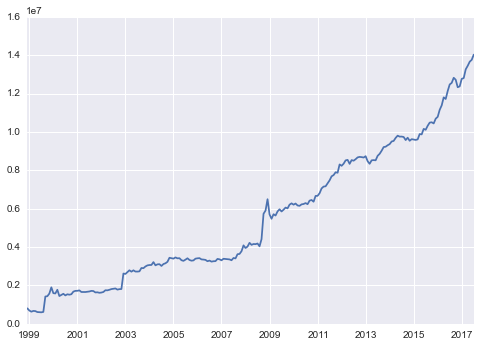

In [45]:
(central_banks_asset/fx).dropna(how='all').sum(axis=1).plot()

In [47]:
factors['Central Bank Assets']=(central_banks_asset/fx).dropna(how='all').sum(axis=1).resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


In [9]:
factors['Amihud']=np.log(amihud.median(axis=1).dropna())

I need to understand what the VAR should look like.  Previously I used something that looked like this:

$$ X_t = \mu + \Phi X_{t-1} - \Sigma \varepsilon_t $$

But what is X in this case?

In [48]:
factors.columns

Index([u'Amihud', u'LIBOR', u'FedFunds', u'TED', u'FinancialStress',
       u'NBER_Recessions', u'Pastor and Stambaugh (2003)',
       u'Central Bank Assets'],
      dtype='object')

In [73]:

col=[u'Amihud', u'LIBOR', u'FinancialStress','Central Bank Assets']

In [74]:
res = VAR.VAR(endog=factors[col].dropna()).fit()
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 26, Aug, 2017
Time:                     11:09:52
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    17.2584
Nobs:                     190.000    HQIC:                   17.0550
Log likelihood:          -2665.47    FPE:                2.22230e+07
AIC:                      16.9166    Det(Omega_mle):     2.00299e+07
--------------------------------------------------------------------
Results for equation Amihud
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -3.452792         0.843920           -4.091           0.000
L1.Amihud                      0.837260         0.039885           20.992           0.000
L1.LIBOR               

In [75]:
df=pd.DataFrame()
df['Values']=res.params.Amihud
df['Tstat']=res.tvalues.Amihud

In [76]:
df

,Values,Tstat
const,-3.452792e+00,-4.091371
L1.Amihud,8.372603e-01,20.991777
L1.LIBOR,-2.415870e-02,-2.215637
L1.FinancialStress,1.010219e-02,0.749149
L1.Central Bank Assets,-5.126004e-08,-3.680047


In [77]:
x=res.params.Amihud

In [78]:
y=pd.DataFrame()
y['Results']=res.params.Amihud.append(res.tvalues.Amihud)

In [79]:
print y.round(2).to_latex()

\begin{tabular}{lr}
\toprule
{} &  Results \\
\midrule
const                  &    -3.45 \\
L1.Amihud              &     0.84 \\
L1.LIBOR               &    -0.02 \\
L1.FinancialStress     &     0.01 \\
L1.Central Bank Assets &    -0.00 \\
const                  &    -4.09 \\
L1.Amihud              &    20.99 \\
L1.LIBOR               &    -2.22 \\
L1.FinancialStress     &     0.75 \\
L1.Central Bank Assets &    -3.68 \\
\bottomrule
\end{tabular}



In [82]:
res = VAR.VAR(endog=factors[col].dropna()).fit(2)
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 26, Aug, 2017
Time:                     11:10:18
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    16.7444
Nobs:                     189.000    HQIC:                   16.3771
Log likelihood:          -2560.71    FPE:                1.00917e+07
AIC:                      16.1269    Det(Omega_mle):     8.37817e+06
--------------------------------------------------------------------
Results for equation Amihud
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -2.674245         0.903150           -2.961           0.003
L1.Amihud                      0.653606         0.072615            9.001           0.000
L1.LIBOR               

In [83]:
res = VAR.VAR(endog=factors[col].dropna()).fit(3)
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 26, Aug, 2017
Time:                     11:10:18
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    16.9117
Nobs:                     188.000    HQIC:                   16.3792
Log likelihood:          -2520.60    FPE:                9.04241e+06
AIC:                      16.0166    Det(Omega_mle):     6.92040e+06
--------------------------------------------------------------------
Results for equation Amihud
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -1.782732         0.951855           -1.873           0.063
L1.Amihud                      0.612554         0.074481            8.224           0.000
L1.LIBOR               

In [84]:
model = VAR.VAR(endog=factors[col].dropna())

In [85]:
model.select_order(14)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         28.11        28.18    1.614e+12        28.14
1         17.02        17.38    2.470e+07        17.17
2         16.13       16.77*    1.009e+07        16.39
3         15.91        16.85    8.163e+06       16.29*
4         15.81        17.03    7.393e+06        16.31
5        15.76*        17.27   7.034e+06*        16.37
6         15.86        17.66    7.790e+06        16.59
7         15.94        18.02    8.433e+06        16.78
8         16.02        18.39    9.204e+06        16.98
9         15.92        18.57    8.388e+06        16.99
10        15.93        18.88    8.604e+06        17.13
11        15.92        19.15    8.592e+06        17.23
12        15.96        19.48    9.077e+06        17.39
13        15.94        19.75    9.071e+06        17.49
14        15.96        20.05    9.379e+06        17.62
* Minimum


{'aic': 5, 'bic': 2, 'fpe': 5, 'hqic': 3}

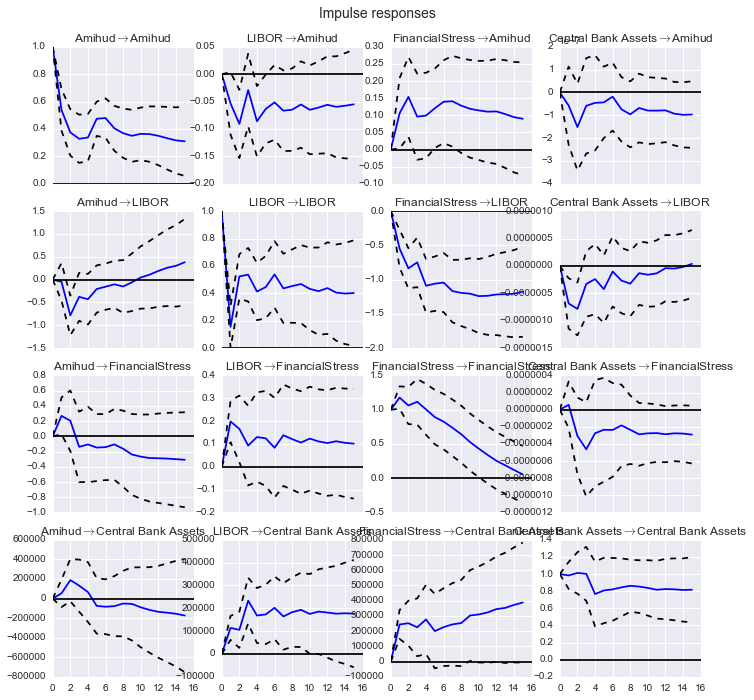

In [86]:
resaic = model.fit(maxlags=20,ic='aic')
irf=resaic.irf(15)
sns.set(font_scale=1)
irf.plot()